# Introduction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

In [2]:
#data = pd.read_csv('data/red_normal.csv')
data = pd.read_csv('data/red_data.csv')
#data = pd.read_csv('data/white_normal.csv')
#data = pd.read_csv('data/white_data.csv')
#data = pd.read_csv('data/wine_normal.csv')
#data = pd.read_csv('data/wine_data.csv')
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.shape

(1599, 12)

In [4]:
pca_flag = True
interaction_flag = True

Our approach is to think about the train as points sitting in $\mathbb R^{12}$ and we conjecture that they have some structure in the form of lower dimensional shape. To have a more concrete visualization, think about $\mathbb R^3$ an our train might have the shape of a sphere, a torus, a bent sheet of paper etc.

Obviously, the train is going to be pretty irregular and we don't expect it to form a really nice submanifold. Nonetheless, we draw from the notion of a triangulization from geometry. Roughly, it says that we can approximate any shape by only using linear pieces without changing the geometric properties too much.

To translate this into our setting, we are going to divide the ranges of the features into a grid and for each small piece we are going to find a linear model to predict the quality. Given a new example, we only need to find where it lies on the grid and make a prediction using the closest model.

In [5]:
# Optionally generate interaction features x*y and x**2
if interaction_flag:
    from itertools import combinations
    old_features = [name for name in data.columns if not 'type' in name and name != "quality"]
    for feature1, feature2 in combinations(old_features, 2):
        temp = data[feature1] * data[feature2]
        data.insert(data.shape[1]-1, feature1 + 'x' + feature2, temp)

    for name in old_features:
         data.insert(data.shape[1]-1, name + '**2', data[name]*data[name])   

In [6]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,...,citric**2,sugar**2,chlorides**2,free_SD**2,total_SD**2,density**2,pH**2,sulphates**2,alcohol**2,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0000,3.61,0.005776,121.0,1156.0,0.995605,12.3201,0.3136,88.36,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0000,6.76,0.009604,625.0,4489.0,0.993610,10.2400,0.4624,96.04,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0016,5.29,0.008464,225.0,2916.0,0.994009,10.6276,0.4225,96.04,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.3136,3.61,0.005625,289.0,3600.0,0.996004,9.9856,0.3364,96.04,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0000,3.61,0.005776,121.0,1156.0,0.995605,12.3201,0.3136,88.36,5


In [7]:
# Normalize data
if "type_red" in data.columns:
    temp_type = data['type_red']
    data.drop('type_red', axis=1, inplace=True)
    
temp_quality = data['quality']
data.drop('quality', axis=1, inplace=True)

data = (data - data.mean())/data.std()

if "type_red" in data.columns:
    data['type_red'] = temp_type
data['quality'] = temp_quality

In [8]:
data.head()

,fixed_acidity,volatile_acidity,citric,sugar,chlorides,free_SD,total_SD,density,pH,sulphates,...,citric**2,sugar**2,chlorides**2,free_SD**2,total_SD**2,density**2,pH**2,sulphates**2,alcohol**2,quality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,...,-0.896308,-0.278002,-0.184979,-0.481601,-0.407734,0.557410,1.296814,-0.488394,-0.921738,5
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,...,-0.896308,-0.096402,-0.011771,0.528248,0.244153,0.027305,-0.727109,0.001731,-0.591155,5
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,...,-0.883429,-0.181149,-0.063354,-0.273219,-0.063503,0.133283,-0.349977,-0.129694,-0.591155,5
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,...,1.627969,-0.278002,-0.191811,-0.144985,0.070278,0.663495,-0.974638,-0.413294,-0.591155,6
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,...,-0.896308,-0.278002,-0.184979,-0.481601,-0.407734,0.557410,1.296814,-0.488394,-0.921738,5


In [9]:
if pca_flag:
    from sklearn.decomposition import PCA
    # To perform PCA we keep categorical variables in another place
    name_type = [name for name in data.columns if 'type' in name]
    numerical = [name for name in data.columns if 'type' not in name and name != 'quality']
    if len(name_type):
        temp_type = data[name_type]
    temp_quality = data[['quality']]
    data = data[numerical]
    print("data.head()")
    print(data.head(),"\n")
    
    pca = PCA(svd_solver='full')
    pca.fit(data)
    print("explained variance ratio")
    print(pca.explained_variance_ratio_,"\n")
    data = pd.DataFrame(pca.transform(data))
    print("data.head()")
    print(data.head())
    
    if len(name_type):
        data['type_red'] = temp_type
    data['quality'] = temp_quality
    data.rename(columns={0:'alcohol', 1:'density', 2:'volatile_acidity'}, inplace=True)

data.head()
   fixed_acidity  volatile_acidity    citric     sugar  chlorides   free_SD  \
0      -0.528194          0.961576 -1.391037 -0.453077  -0.243630 -0.466047   
1      -0.298454          1.966827 -1.391037  0.043403   0.223805  0.872365   
2      -0.298454          1.296660 -1.185699 -0.169374   0.096323 -0.083643   
3       1.654339         -1.384011  1.483689 -0.453077  -0.264878  0.107558   
4      -0.528194          0.961576 -1.391037 -0.453077  -0.243630 -0.466047   

   total_SD   density        pH  sulphates     ...      volatile_acidity**2  \
0 -0.379014  0.558100  1.288240  -0.579025     ...                 0.825885   
1  0.624168  0.028252 -0.719708   0.128910     ...                 2.135417   
2  0.228975  0.134222 -0.331073  -0.048074     ...                 1.229243   
3  0.411372  0.664069 -0.978798  -0.461036     ...                -1.069344   
4 -0.379014  0.558100  1.288240  -0.579025     ...                 0.825885   

   citric**2  sugar**2  chlorides**2  

In [10]:
data.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,quality
0,-4.998225,1.630300,2.028038,1.174710,-0.992029,0.302428,1.403567,0.017724,1.283991,0.994208,...,0.000315,0.000362,-0.000099,-0.000140,-0.000025,0.000141,-0.000037,-0.000102,-0.000048,5
1,-0.801564,5.603401,3.650254,1.326816,-1.409985,-2.321397,1.094425,-1.052647,-2.037316,-0.593150,...,0.000760,-0.000252,-0.000096,0.000406,0.000180,-0.000068,0.000088,0.000013,-0.000009,5
2,-2.263142,2.590825,2.846086,1.129853,-1.227545,-1.018885,0.974722,0.270958,-1.242024,0.008111,...,0.000520,-0.000102,0.000020,0.000231,0.000062,-0.000140,0.000125,-0.000004,-0.000012,5
3,3.664233,-3.523255,-3.232960,-1.081869,-3.790525,1.179744,-0.345020,-0.335266,0.319086,0.706411,...,0.000628,-0.000414,-0.000623,0.000002,0.000082,-0.000580,-0.000086,0.000032,-0.000007,6
4,-4.998225,1.630300,2.028038,1.174710,-0.992029,0.302428,1.403567,0.017724,1.283991,0.994208,...,0.000315,0.000362,-0.000099,-0.000140,-0.000025,0.000141,-0.000037,-0.000102,-0.000048,5


In [11]:
train = data.sample(frac=0.8).sort_index()

In [12]:
X_train, y_train = train.ix[:,:-1], train.quality

In [13]:
train_index = train.index

In [14]:
train_index.shape

(1279,)

In [15]:
test = data.iloc[~data.index.isin(train_index)]

In [16]:
test.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,quality
5,-4.683970,1.931586,1.588230,0.646817,-1.123801,0.528492,1.486519,-0.047682,1.218445,1.226009,...,0.000357,0.000387,-0.000011,-0.000254,-0.000032,0.000173,-0.000097,-0.000148,-0.000049,5
16,6.843481,2.291805,-3.851054,-5.417842,-1.374942,0.523166,-1.016474,-0.215061,1.542714,-0.174947,...,-0.000524,0.000150,0.000491,0.000059,0.000041,0.000117,-0.000029,-0.000052,-0.000014,7
20,2.205279,-0.107594,-3.932140,-2.961455,-2.276714,3.297744,-0.081262,-1.693373,2.131277,0.122392,...,0.000815,-0.000597,-0.001401,0.000546,0.000592,-0.000881,0.000651,-0.000243,0.000111,6
21,0.843668,1.870077,-1.597657,-1.839657,-0.460678,1.558371,0.819354,0.357453,2.641090,1.138576,...,-0.000202,-0.000011,0.000389,-0.000621,-0.000105,0.000378,-0.000239,-0.000045,-0.000020,5
22,-0.496737,-1.965651,1.987832,-2.368444,-0.079894,0.707879,2.996198,1.377256,-1.291802,-0.719011,...,0.000203,-0.000329,0.000187,-0.000093,-0.000052,-0.000140,0.000066,0.000140,-0.000026,5


In [17]:
train.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,quality
0,-4.998225,1.630300,2.028038,1.174710,-0.992029,0.302428,1.403567,0.017724,1.283991,0.994208,...,0.000315,0.000362,-0.000099,-0.000140,-0.000025,0.000141,-0.000037,-0.000102,-0.000048,5
1,-0.801564,5.603401,3.650254,1.326816,-1.409985,-2.321397,1.094425,-1.052647,-2.037316,-0.593150,...,0.000760,-0.000252,-0.000096,0.000406,0.000180,-0.000068,0.000088,0.000013,-0.000009,5
2,-2.263142,2.590825,2.846086,1.129853,-1.227545,-1.018885,0.974722,0.270958,-1.242024,0.008111,...,0.000520,-0.000102,0.000020,0.000231,0.000062,-0.000140,0.000125,-0.000004,-0.000012,5
3,3.664233,-3.523255,-3.232960,-1.081869,-3.790525,1.179744,-0.345020,-0.335266,0.319086,0.706411,...,0.000628,-0.000414,-0.000623,0.000002,0.000082,-0.000580,-0.000086,0.000032,-0.000007,6
4,-4.998225,1.630300,2.028038,1.174710,-0.992029,0.302428,1.403567,0.017724,1.283991,0.994208,...,0.000315,0.000362,-0.000099,-0.000140,-0.000025,0.000141,-0.000037,-0.000102,-0.000048,5


In [18]:
train.describe()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,quality
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,...,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1.279000e+03,1279.000000,1.279000e+03,1279.000000
mean,0.029253,0.009525,0.032728,0.056359,0.054400,0.008378,0.017605,-0.004311,0.026073,0.010524,...,-0.000002,-0.000005,0.000007,-0.000004,-0.000006,0.000003,8.046720e-07,0.000004,5.535677e-07,5.623143
std,4.583931,4.018845,3.142903,2.979798,2.596399,2.128162,1.844351,1.777762,1.324972,1.088441,...,0.000598,0.000528,0.000519,0.000378,0.000369,0.000283,2.642458e-04,0.000214,1.022994e-04,0.816667
min,-8.267013,-9.550064,-13.726845,-12.962716,-8.840812,-9.259833,-8.886045,-7.825155,-4.931543,-5.244524,...,-0.003278,-0.005024,-0.003090,-0.001673,-0.002159,-0.001394,-1.360160e-03,-0.001384,-4.030096e-04,3.000000
25%,-3.186481,-2.762871,-1.679844,-1.548814,-1.677149,-1.101991,-1.074135,-0.873142,-0.825940,-0.664739,...,-0.000252,-0.000157,-0.000173,-0.000165,-0.000113,-0.000129,-1.056546e-04,-0.000092,-4.754268e-05,5.000000
50%,-0.583156,0.249338,-0.254428,-0.123608,-0.102470,0.189709,0.078954,-0.035586,-0.007451,0.012907,...,0.000008,0.000010,0.000036,0.000026,0.000022,-0.000004,2.880719e-06,-0.000001,-1.550958e-05,6.000000
75%,2.387572,2.530756,1.191492,1.319287,1.699692,1.246595,1.046262,0.724037,0.870500,0.657667,...,0.000258,0.000183,0.000244,0.000170,0.000151,0.000131,1.049901e-04,0.000102,2.108785e-05,6.000000
max,37.251859,20.175084,30.317121,20.058543,12.322637,9.636555,10.677498,13.753947,4.643357,5.745160,...,0.004567,0.006101,0.004927,0.001911,0.001541,0.001566,2.079578e-03,0.001519,8.021453e-04,8.000000


In [19]:
# Dictionary representing the gird. Each row represents a feature and the columns the partitions.
# The shape of this matrix is a hyperparameter of our model.
# The distance notion that we use is also a hyperparameter.
grid = {}
for name in ['alcohol', 'density', 'volatile_acidity']: #train.columns:
    if not "type" in name:
        grid[name] = []

In [20]:
grid

{'alcohol': [], 'density': [], 'volatile_acidity': []}

In [21]:
# We start small, for each feature we just give one separation point.
for element in grid:
    grid[element] = np.median(train[element])

In [22]:
grid

{'alcohol': -0.58315588642995853,
 'density': 0.24933845398708601,
 'volatile_acidity': -0.25442783943974007}

This generates a split of the train into $2^{12}$ pieces. That is 4096 different pieces so we don't have enough train to support this partition. We need to select a subset of the feautes.

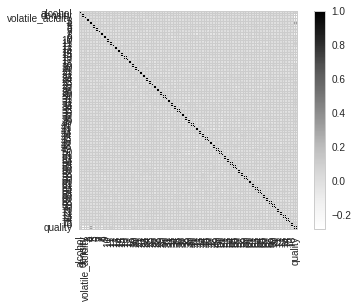

In [23]:
tick_marks = [i for i in range(len(train.columns))]
plt.imshow(train.corr(), interpolation='nearest')
plt.colorbar()
plt.xticks(tick_marks, train.columns, rotation='vertical')
plt.yticks(tick_marks, train.columns)
plt.show()

In [24]:
correlations = pd.DataFrame(train.corr()['quality']).apply(np.abs)
correlations.sort_values(by='quality', ascending=False)

,quality
quality,1.000000
4,0.314283
density,0.278506
volatile_acidity,0.272221
3,0.157370
8,0.145801
5,0.138998
15,0.106560
18,0.094787
13,0.082722


It seems reasonable to split along alcohol, density and volatile_acidity. This way we will have 8 different partitions

In [25]:
dfs = []

In [26]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density > grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [27]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density > grid["density"] ) 
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [28]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [29]:
dfs.append(train[(train.alcohol > grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [30]:
dfs.append(train[(train.alcohol < grid["alcohol"])
                 & (train.density > grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [31]:
dfs.append(train[(train.alcohol < grid["alcohol"]) 
                 & (train.density > grid["density"])
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [32]:
dfs.append(train[(train.alcohol < grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity > grid["volatile_acidity"])])

In [33]:
dfs.append(train[(train.alcohol < grid["alcohol"]) 
                 & (train.density < grid["density"]) 
                 & (train.volatile_acidity < grid["volatile_acidity"])])

In [34]:
for df in dfs:
    print(df.shape)

(111, 78)
(173, 78)
(99, 78)
(256, 78)
(267, 78)
(86, 78)
(162, 78)
(120, 78)


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score

In [36]:
def trainLG(df):
    X, y = df.ix[:,:-1], df['quality']
    clf = LogisticRegression(penalty='l2', C=10, n_jobs=-1)
    clf.fit(X, y)
    return clf

In [37]:
clfs = []
for df in dfs:
    clfs.append(trainLG(df))

In [38]:
X_test, y_test = test.ix[:,:-1], test['quality']

In [39]:
X_test.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
5,-4.683970,1.931586,1.588230,0.646817,-1.123801,0.528492,1.486519,-0.047682,1.218445,1.226009,...,0.000012,0.000357,0.000387,-0.000011,-0.000254,-0.000032,0.000173,-0.000097,-0.000148,-0.000049
16,6.843481,2.291805,-3.851054,-5.417842,-1.374942,0.523166,-1.016474,-0.215061,1.542714,-0.174947,...,0.000037,-0.000524,0.000150,0.000491,0.000059,0.000041,0.000117,-0.000029,-0.000052,-0.000014
20,2.205279,-0.107594,-3.932140,-2.961455,-2.276714,3.297744,-0.081262,-1.693373,2.131277,0.122392,...,-0.000252,0.000815,-0.000597,-0.001401,0.000546,0.000592,-0.000881,0.000651,-0.000243,0.000111
21,0.843668,1.870077,-1.597657,-1.839657,-0.460678,1.558371,0.819354,0.357453,2.641090,1.138576,...,0.000343,-0.000202,-0.000011,0.000389,-0.000621,-0.000105,0.000378,-0.000239,-0.000045,-0.000020
22,-0.496737,-1.965651,1.987832,-2.368444,-0.079894,0.707879,2.996198,1.377256,-1.291802,-0.719011,...,0.000145,0.000203,-0.000329,0.000187,-0.000093,-0.000052,-0.000140,0.000066,0.000140,-0.000026


In [40]:
def getPiece(row): 
    if row.alcohol > grid["alcohol"]:
        if row.density > grid["density"]:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 0
            else:
                return 1
        else:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 2
            else:
                return 3
    else:
        if row.density > grid["density"]:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 4
            else:
                return 5
        else:
            if row.volatile_acidity > grid["volatile_acidity"]:
                return 6
            else:
                return 7
        
def generatePrediction(df): # predicts using the classifier from the region
    y_pred = []
    for idx in df.index:
        temp = getPiece(df.loc[idx])
        jdx = clfs[temp].predict(df.loc[idx].values.reshape(1,-1))
        y_pred.append(jdx)
    return pd.DataFrame(y_pred)

In [41]:
y_pred = generatePrediction(X_test)

## Results

In [42]:
print("MAE =", mean_absolute_error(y_test, y_pred))
print("Acc. =", accuracy_score(y_test, y_pred))

MAE = 0.403125
Acc. = 0.621875


## Using Ensemble of all the grid pieces

In [43]:
X_train, y_train = train.ix[:,:-1], train['quality']

In [44]:
X_train.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,-4.998225,1.630300,2.028038,1.174710,-0.992029,0.302428,1.403567,0.017724,1.283991,0.994208,...,-0.000030,0.000315,0.000362,-0.000099,-0.000140,-0.000025,0.000141,-0.000037,-0.000102,-0.000048
1,-0.801564,5.603401,3.650254,1.326816,-1.409985,-2.321397,1.094425,-1.052647,-2.037316,-0.593150,...,0.000324,0.000760,-0.000252,-0.000096,0.000406,0.000180,-0.000068,0.000088,0.000013,-0.000009
2,-2.263142,2.590825,2.846086,1.129853,-1.227545,-1.018885,0.974722,0.270958,-1.242024,0.008111,...,0.000294,0.000520,-0.000102,0.000020,0.000231,0.000062,-0.000140,0.000125,-0.000004,-0.000012
3,3.664233,-3.523255,-3.232960,-1.081869,-3.790525,1.179744,-0.345020,-0.335266,0.319086,0.706411,...,-0.000344,0.000628,-0.000414,-0.000623,0.000002,0.000082,-0.000580,-0.000086,0.000032,-0.000007
4,-4.998225,1.630300,2.028038,1.174710,-0.992029,0.302428,1.403567,0.017724,1.283991,0.994208,...,-0.000030,0.000315,0.000362,-0.000099,-0.000140,-0.000025,0.000141,-0.000037,-0.000102,-0.000048


In [45]:
p = X_train.shape[1]

In [46]:
X_test.head()

,alcohol,density,volatile_acidity,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
5,-4.683970,1.931586,1.588230,0.646817,-1.123801,0.528492,1.486519,-0.047682,1.218445,1.226009,...,0.000012,0.000357,0.000387,-0.000011,-0.000254,-0.000032,0.000173,-0.000097,-0.000148,-0.000049
16,6.843481,2.291805,-3.851054,-5.417842,-1.374942,0.523166,-1.016474,-0.215061,1.542714,-0.174947,...,0.000037,-0.000524,0.000150,0.000491,0.000059,0.000041,0.000117,-0.000029,-0.000052,-0.000014
20,2.205279,-0.107594,-3.932140,-2.961455,-2.276714,3.297744,-0.081262,-1.693373,2.131277,0.122392,...,-0.000252,0.000815,-0.000597,-0.001401,0.000546,0.000592,-0.000881,0.000651,-0.000243,0.000111
21,0.843668,1.870077,-1.597657,-1.839657,-0.460678,1.558371,0.819354,0.357453,2.641090,1.138576,...,0.000343,-0.000202,-0.000011,0.000389,-0.000621,-0.000105,0.000378,-0.000239,-0.000045,-0.000020
22,-0.496737,-1.965651,1.987832,-2.368444,-0.079894,0.707879,2.996198,1.377256,-1.291802,-0.719011,...,0.000145,0.000203,-0.000329,0.000187,-0.000093,-0.000052,-0.000140,0.000066,0.000140,-0.000026


In [47]:
# Expand add predictions from the segmented classifiers to X_train and X_test
for idx, clf in enumerate(clfs):
    temp = clf.predict(X_train.ix[:,:p])
    X_train.insert(X_train.shape[1], 'clf_' + str(idx), temp)
    temp = clf.predict(X_test.ix[:,:p])
    X_test.insert(X_test.shape[1], 'clf_' + str(idx), temp)

In [48]:
clf = LogisticRegression(penalty='l2', C=10, n_jobs=-1)
clf.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
y_pred = clf.predict(X_test)
print("MAE =", mean_absolute_error(y_test, y_pred))
print("Acc. =", accuracy_score(y_test, y_pred))

MAE = 0.378125
Acc. = 0.65


### Only using the predictions

In [50]:
clf = LogisticRegression(penalty='l2', C=10, n_jobs=-1)
clf.fit(X_train.ix[:, p:], y_train)
y_pred = clf.predict(X_test.ix[:, p:])
print("MAE =", mean_absolute_error(y_test, y_pred))
print("Acc. =", accuracy_score(y_test, y_pred))

MAE = 0.38125
Acc. = 0.65
